### Import Libraries


In [1]:
import pandas as pd
import pathlib
from joblib import load

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_confusion_matrix

### Load Datasets


In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)


### Specify Results Directory


In [3]:
# specify results directory
results_dir = pathlib.Path("evaluations/")
cm_dir = pathlib.Path(f"{results_dir}/confusion_matrices/")
cm_dir.mkdir(parents=True, exist_ok=True)


### Evaluate Each Model on Each Dataset

#### Note: `cm` stands for confusion matrix in variable names


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


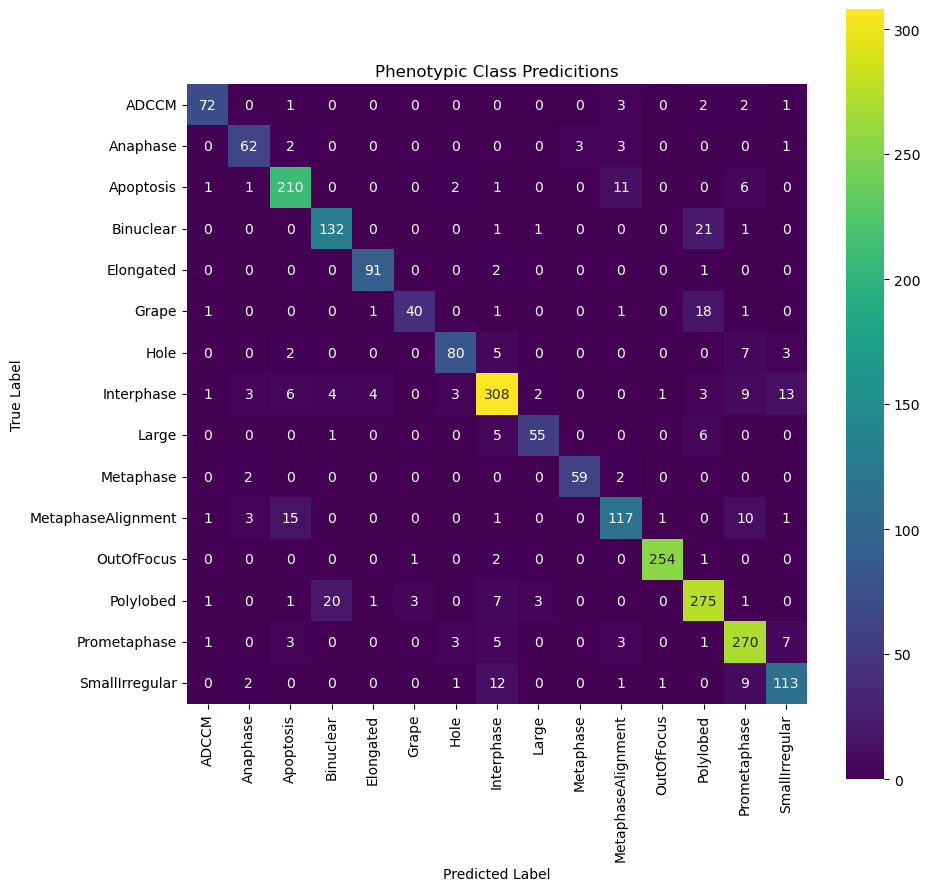

Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: test


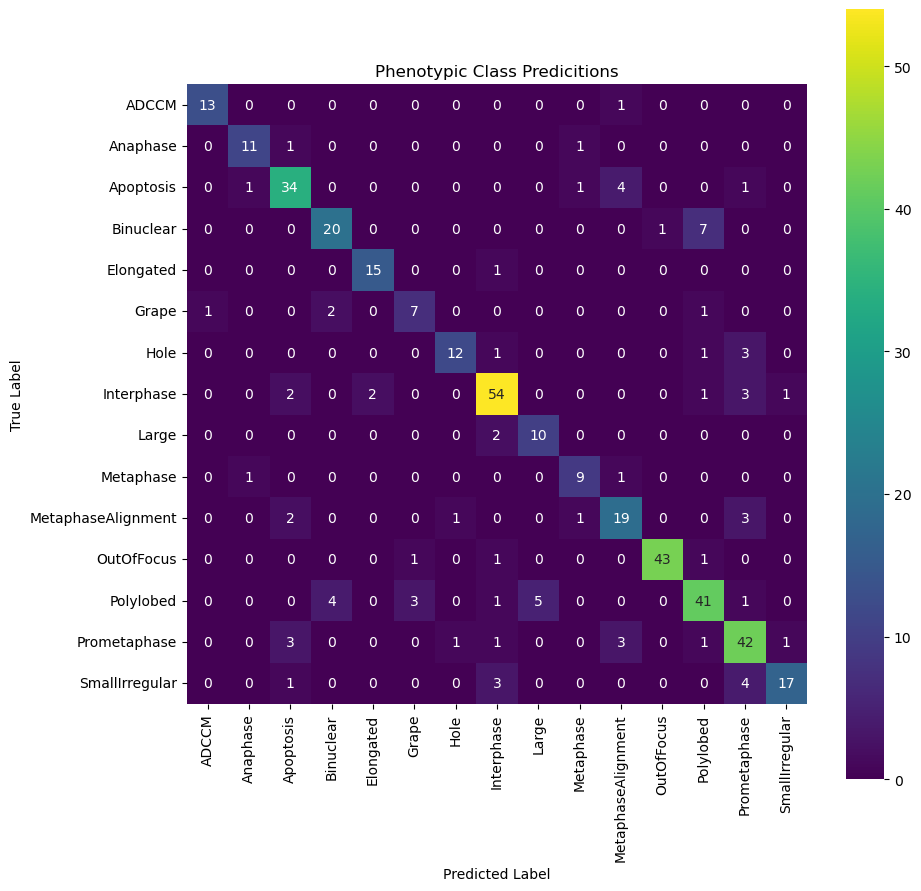

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: train


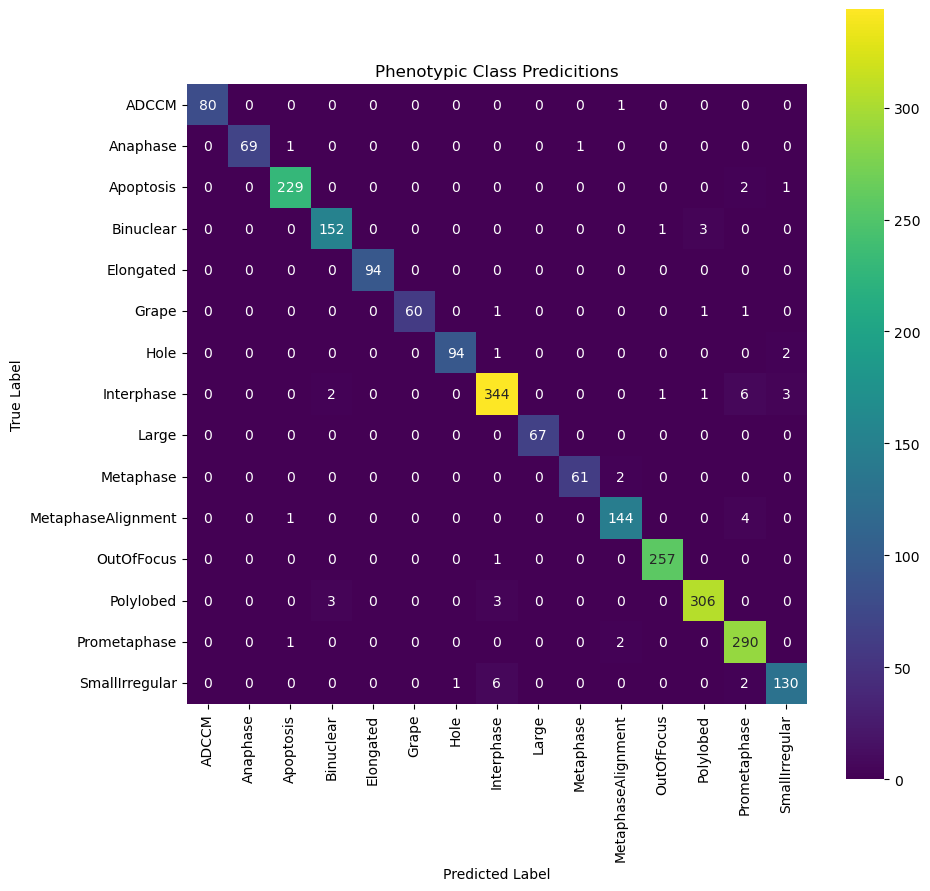

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: test


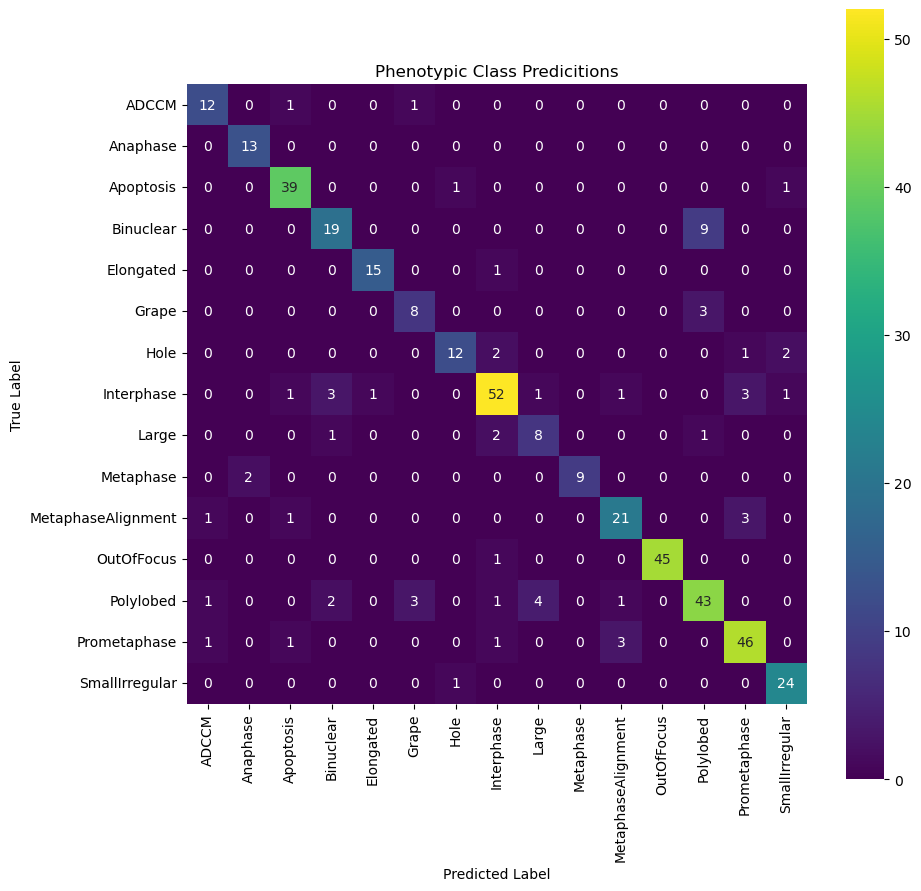

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: train


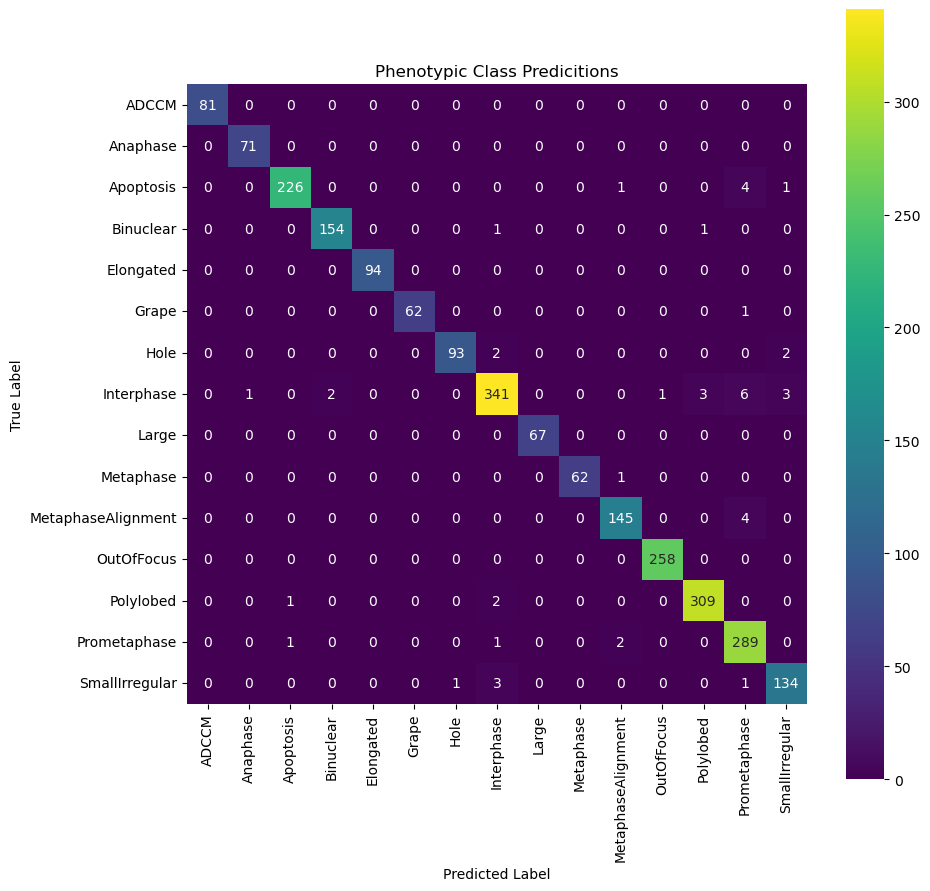

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: test


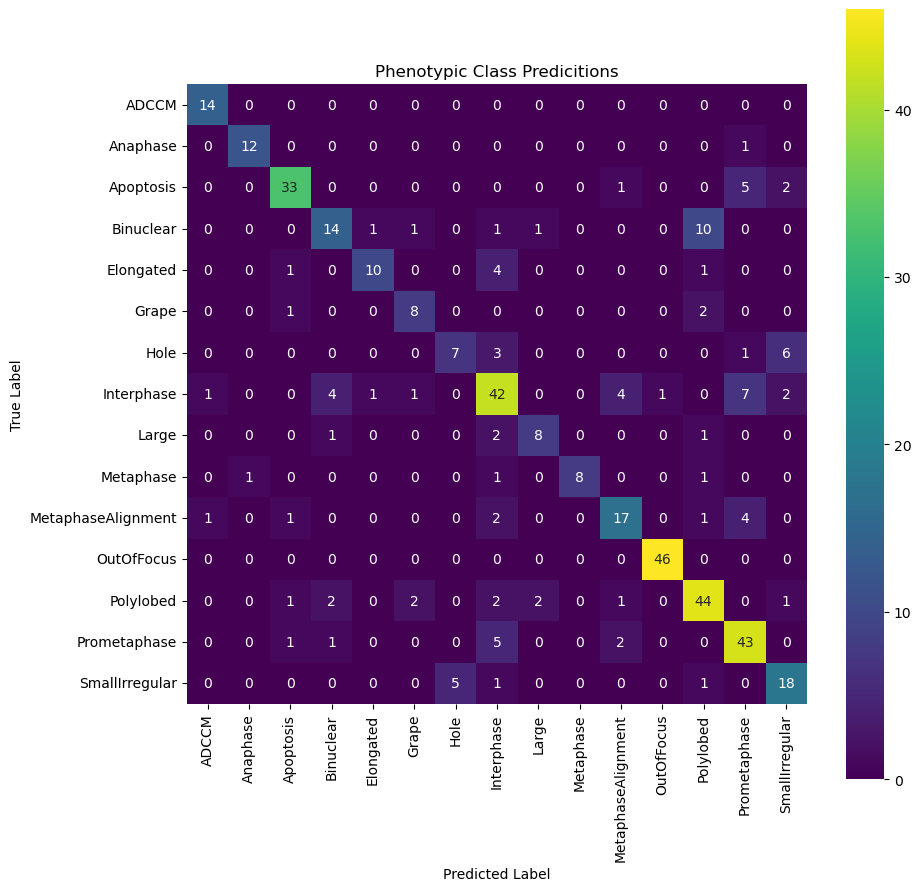

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: train


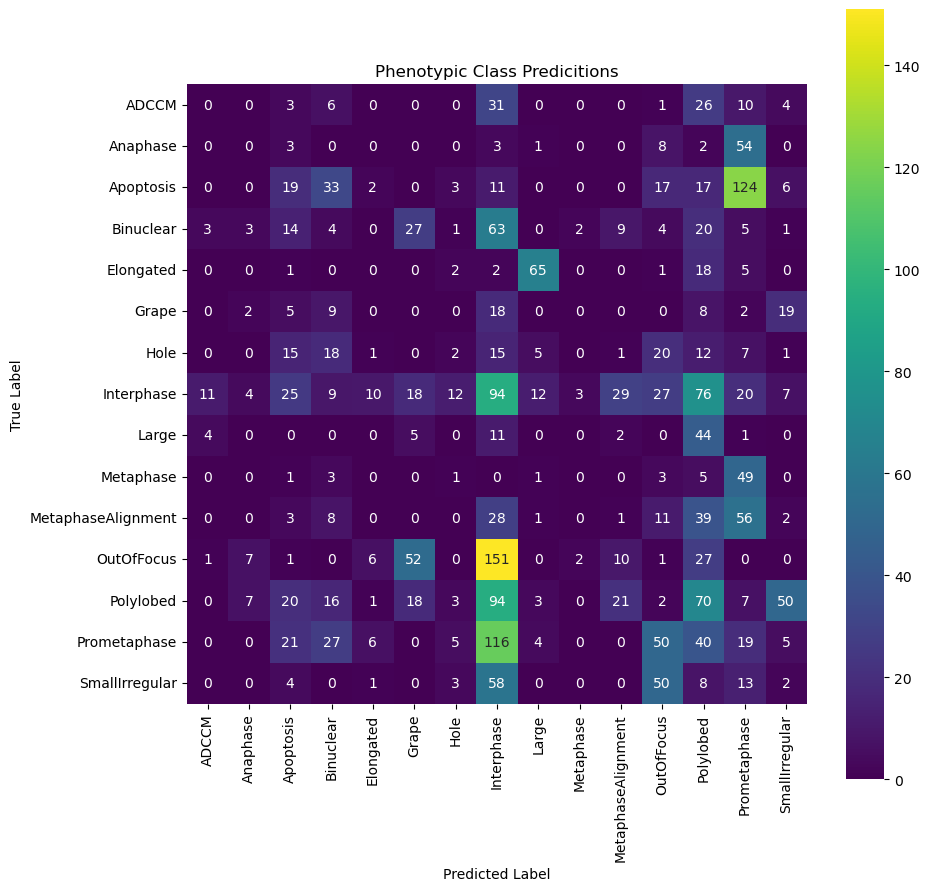

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: test


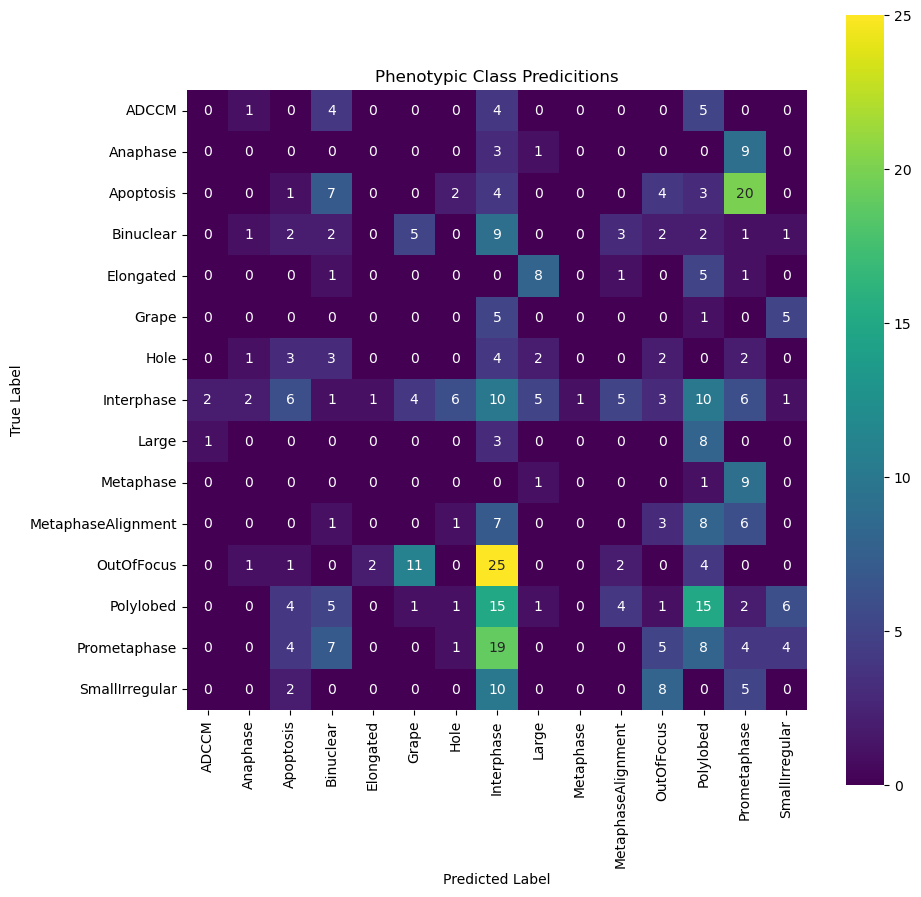

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: train


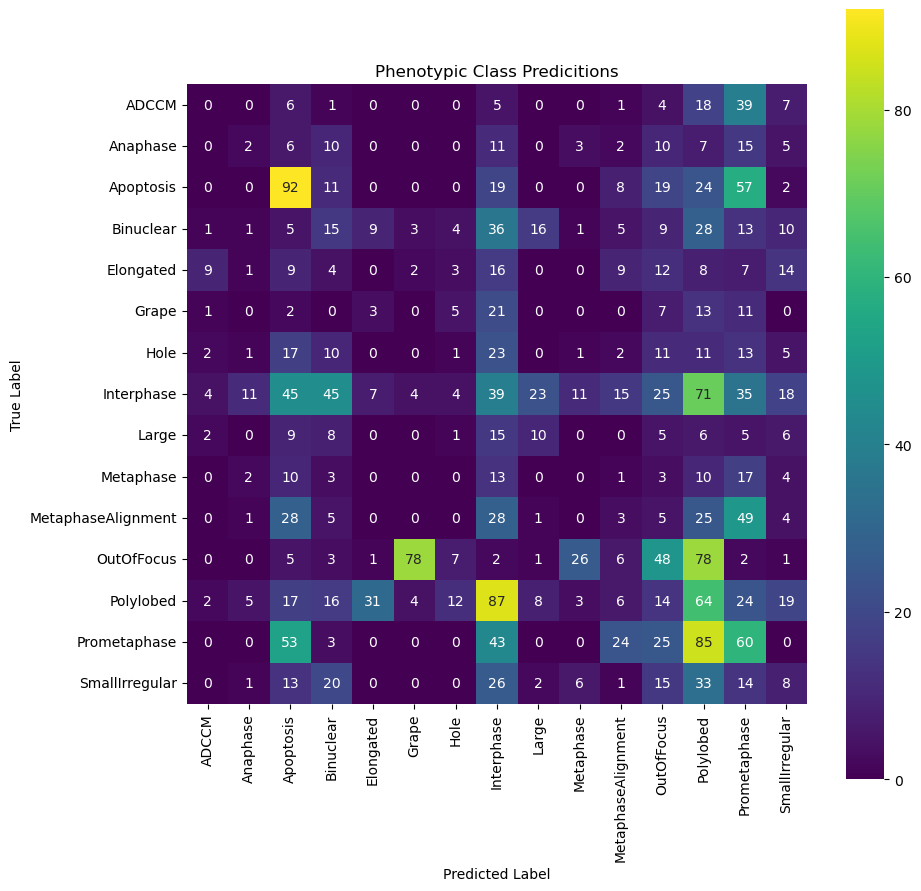

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: test


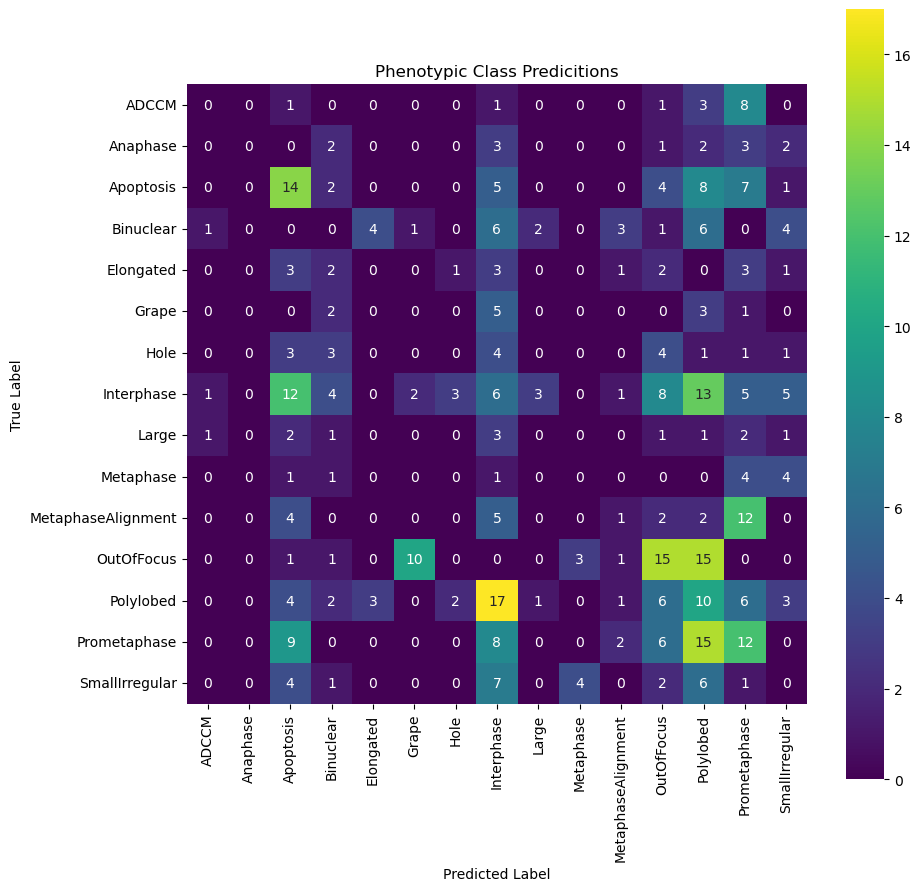

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: train


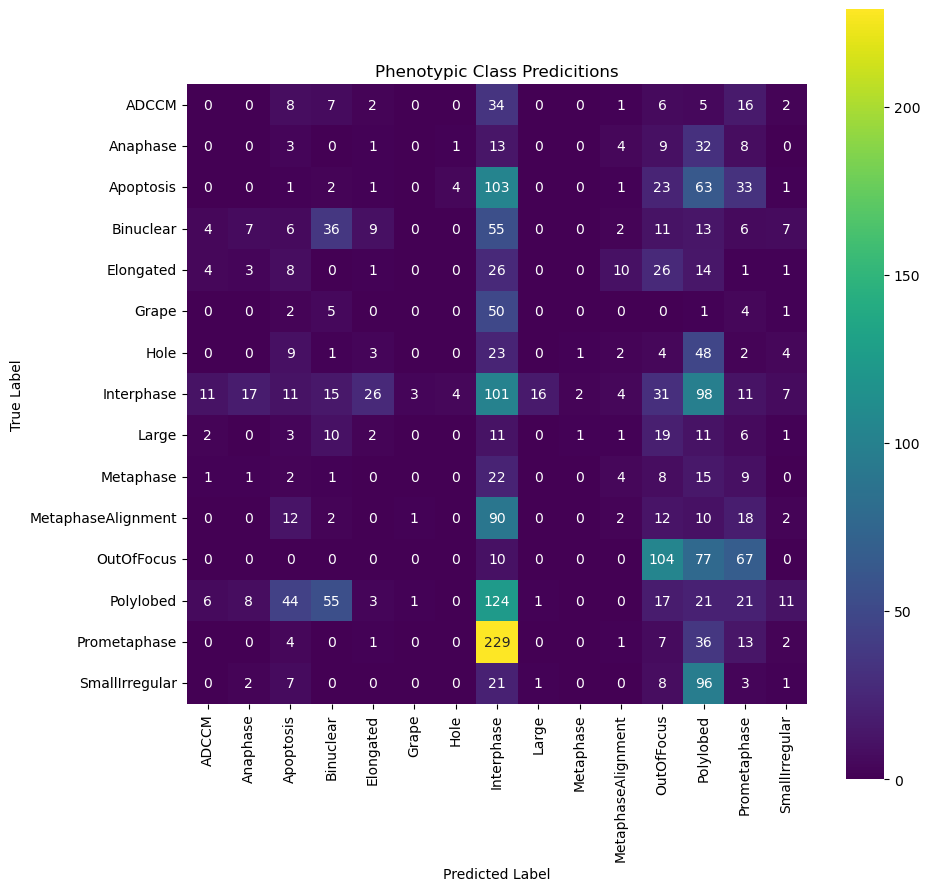

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: test


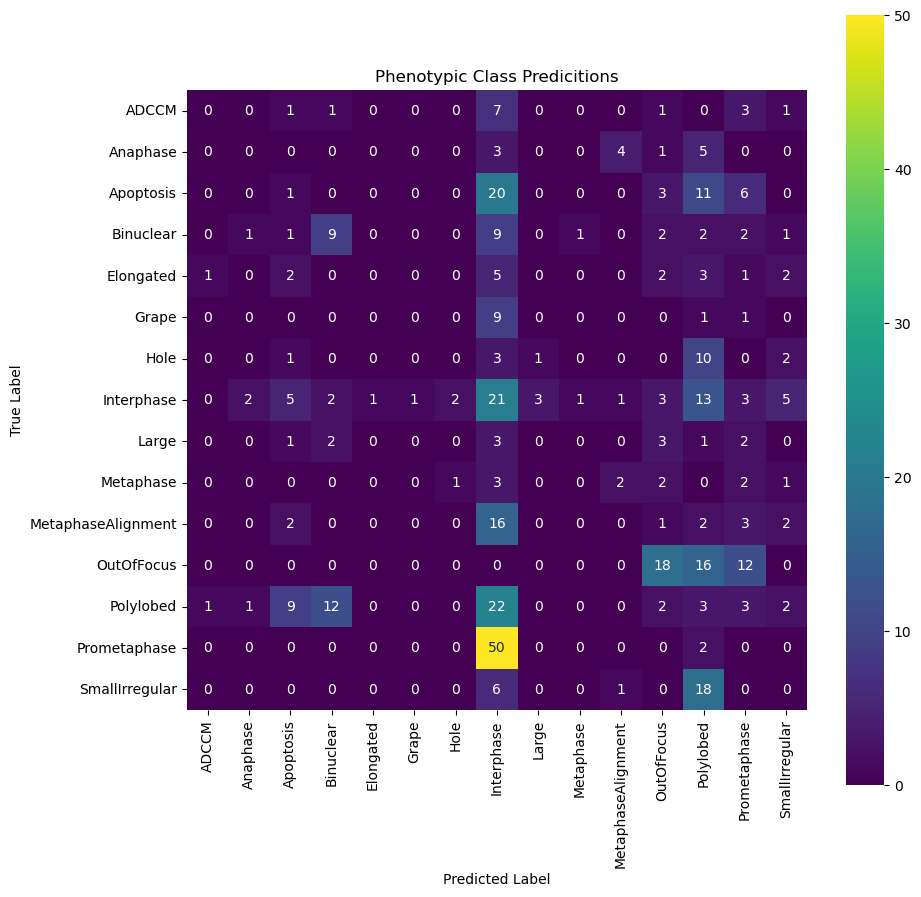

In [4]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_cm_data = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # find confusion matrix for chosen model evaluated on chosen dataset
        cm_data = model_confusion_matrix(model, data, feature_type)

        # add confusion matrix data to compiled dataframe in tidy format
        # use stack to restructure dataframe into tidy long format
        cm_data = cm_data.stack()
        # reset index must be used to make indexes at level 0 and 1 into individual columns
        # these columns correspond to true label and predicted label, and are set as indexes after using stack()
        cm_data = pd.DataFrame(cm_data).reset_index(level=[0, 1])
        cm_data.columns = ["True_Label", "Predicted_Label", "Count"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        cm_data["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        cm_data["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        cm_data["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_cm_data.append(cm_data)


### Save scores from each evaluation


In [5]:
# compile list of tidy data into one dataframe
compiled_cm_data = pd.concat(compiled_cm_data).reset_index(drop=True)

# specify results directory
cm_data_dir = pathlib.Path("evaluations/confusion_matrices/")
cm_data_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_cm_data_save_path = pathlib.Path(f"{cm_data_dir}/compiled_cm_data.tsv")

# save data as tsv
compiled_cm_data.to_csv(compiled_cm_data_save_path, sep="\t")

# preview tidy data
compiled_cm_data


,True_Label,Predicted_Label,Count,data_split,shuffled,feature_type
0,ADCCM,ADCCM,72,train,False,CP
1,ADCCM,Anaphase,0,train,False,CP
2,ADCCM,Apoptosis,1,train,False,CP
3,ADCCM,Binuclear,0,train,False,CP
4,ADCCM,Elongated,0,train,False,CP
...,...,...,...,...,...,...
2695,SmallIrregular,MetaphaseAlignment,1,test,True,DP
2696,SmallIrregular,OutOfFocus,0,test,True,DP
2697,SmallIrregular,Polylobed,18,test,True,DP
2698,SmallIrregular,Prometaphase,0,test,True,DP
